#### Get data from mongoDB

In [1]:
import sys
import os
sys.path.append(os.path.abspath('../ETL_pipeline'))
from get_data_from_cloud import get_dataframe_from_cloud
from dotenv import load_dotenv
from pymongo.mongo_client import MongoClient
from pymongo.server_api import ServerApi

load_dotenv()

# Get environment variables
MONGO_URI = os.getenv('MONGO_URI')
# Create a new client and connect to the server
client = MongoClient(MONGO_URI, server_api=ServerApi('1'))

## Code to plot emissions

In [3]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_top_emissions(data):
    co2_data_filtered = data

    # Select relevant columns for emissions analysis
    emissions_cols = ['country', 'year', 'co2', 'co2_per_capita', 'coal_co2', 'oil_co2', 'gas_co2', 'cement_co2']
    emissions_data = co2_data_filtered[emissions_cols]

    # Group by country and calculate cumulative emissions since 1950
    cumulative_emissions = emissions_data.groupby('country')['co2'].sum().sort_values(ascending=False)

    # Get top 5 emitting countries
    top_emitters = cumulative_emissions.head(5).index.tolist()

    # Filter data for the top emitters
    top_emitters_data = emissions_data[emissions_data['country'].isin(top_emitters)]

    # Plot cumulative emissions for top emitters
    plt.figure(figsize=(12, 6))
    sns.barplot(x=cumulative_emissions.loc[top_emitters].index, y=cumulative_emissions.loc[top_emitters].values)
    plt.title('Cumulative CO₂ Emissions (1950-Present)')
    plt.ylabel('Cumulative Emissions (Million Tonnes)')
    plt.xlabel('Region')
    plt.xticks(rotation=45)
    plt.show()

    # Line plot for emissions over time for top emitters
    plt.figure(figsize=(14, 8))
    for country in top_emitters:
        country_data = top_emitters_data[top_emitters_data['country'] == country]
        plt.plot(country_data['year'], country_data['co2'], label=country)

    plt.legend(title='Country', loc='upper left')  # Customize location and title of legend
    plt.title('CO₂ Emissions Over Time for Top 5 Emitters')
    plt.ylabel('Annual CO₂ Emissions (Million Tonnes)')
    plt.xlabel('Year')
    plt.show()

### EDA most emissions, all regions

In [4]:
df = get_dataframe_from_cloud(client=client, db_name="data", collection_name="emissions")

Pinged your deployment. You successfully connected to MongoDB!


/opt/anaconda3/lib/python3.12/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 8322 (\N{SUBSCRIPT TWO}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


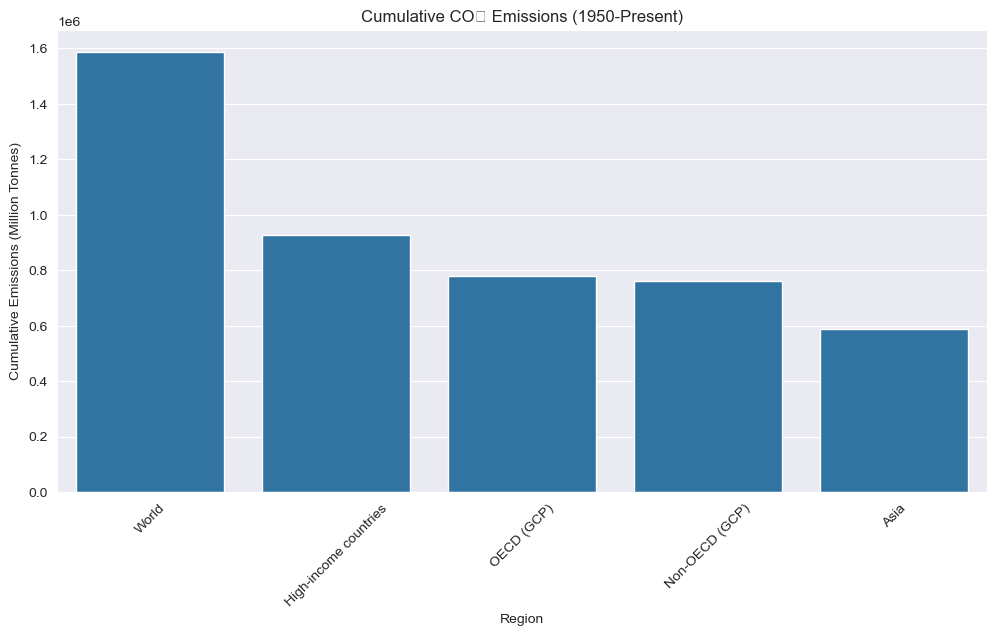

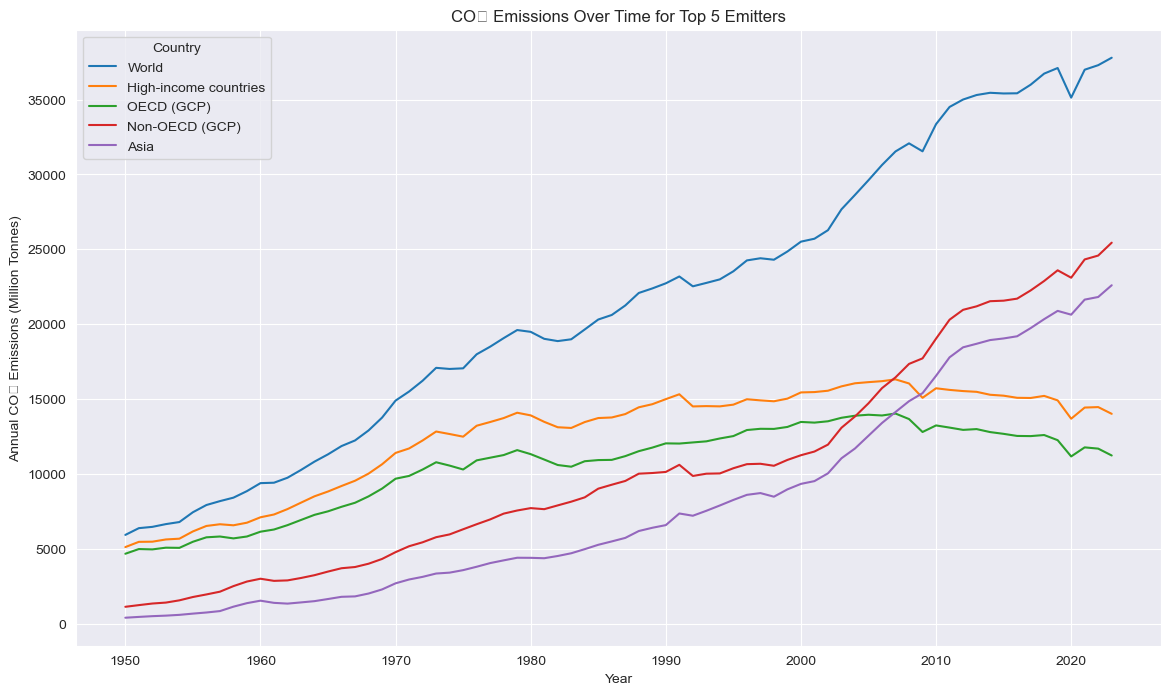

In [5]:
plot_top_emissions(df)

### By Country


Pinged your deployment. You successfully connected to MongoDB!


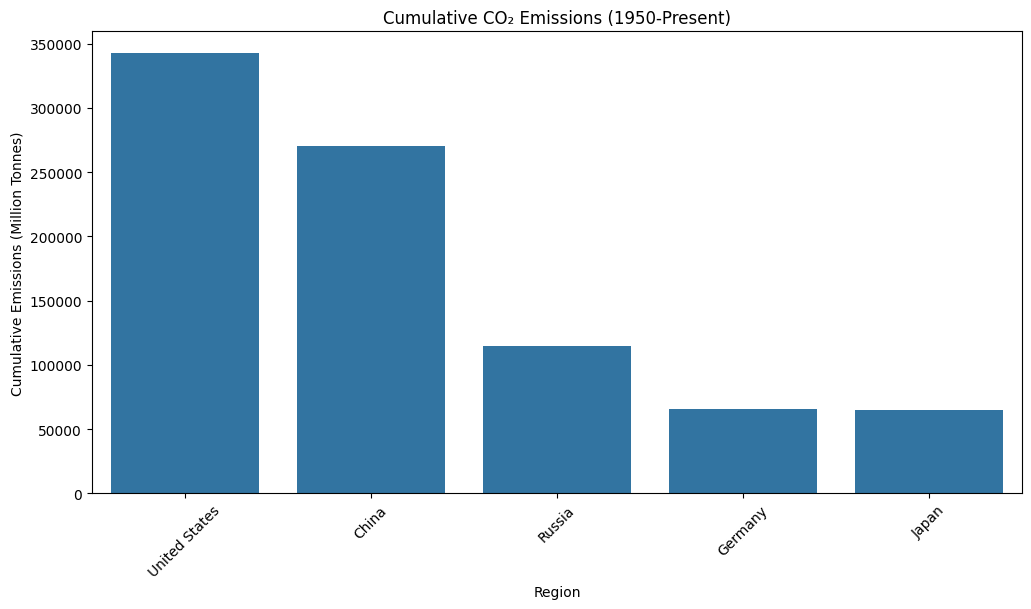

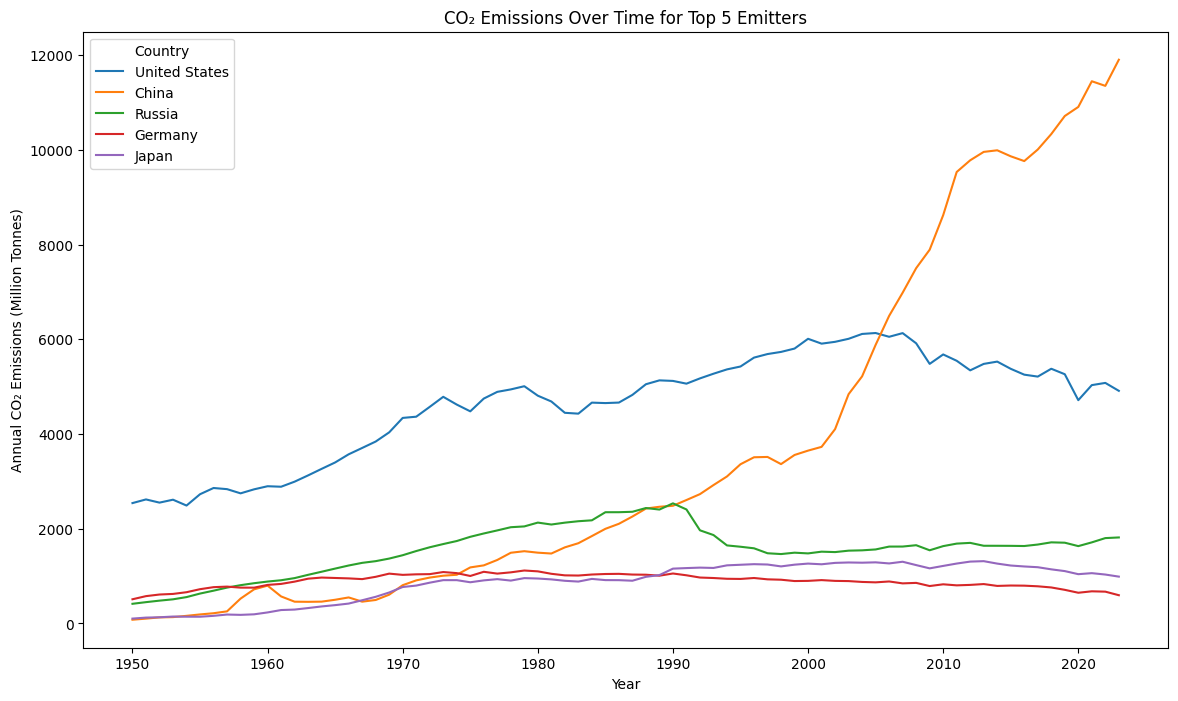

In [9]:
df = get_dataframe_from_cloud(client=client, db_name="data", collection_name="country_data")

plot_top_emissions(df)

### By Continent

Pinged your deployment. You successfully connected to MongoDB!


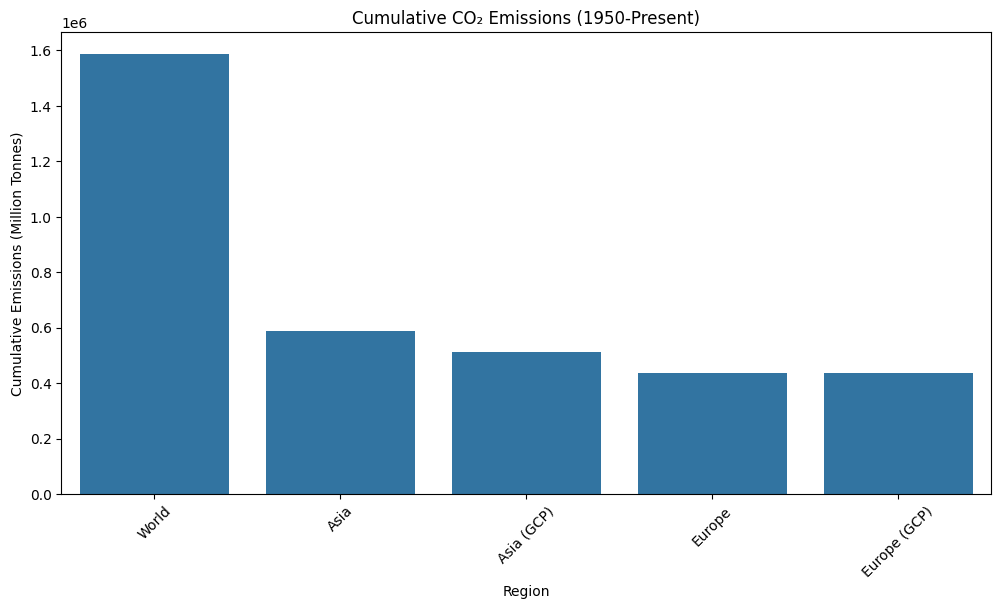

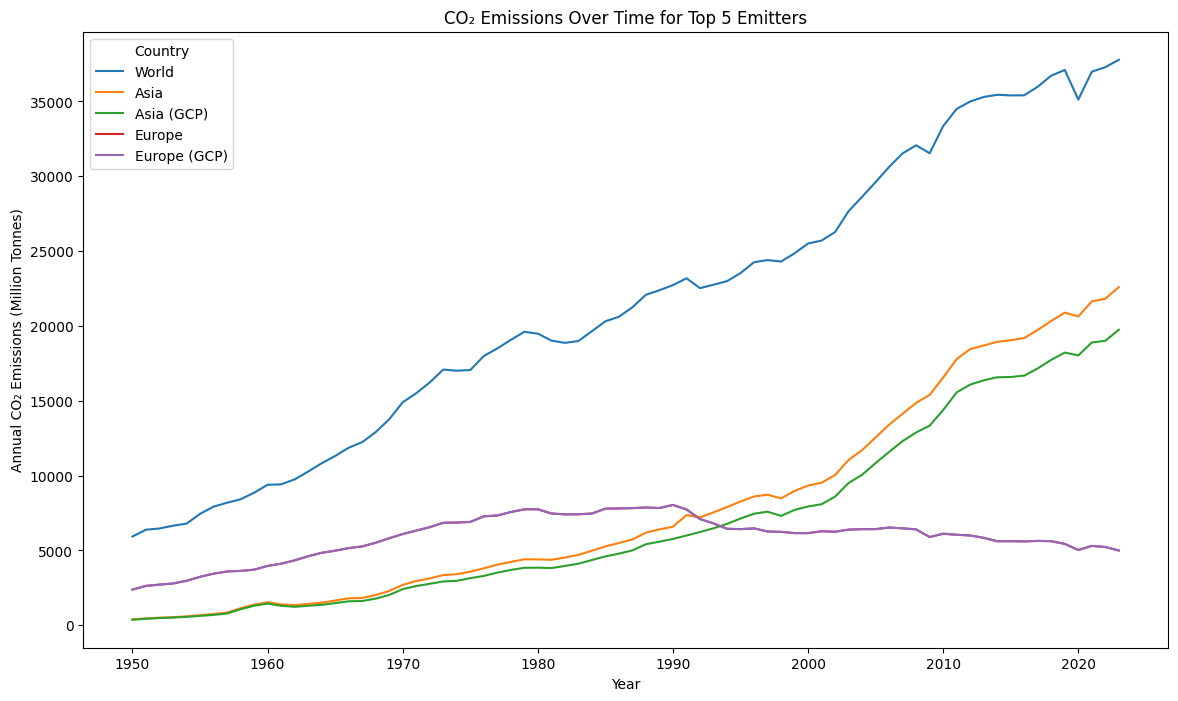

In [10]:
df = get_dataframe_from_cloud(client=client, db_name="data", collection_name="continent_data")

plot_top_emissions(df)

### By Class

Pinged your deployment. You successfully connected to MongoDB!


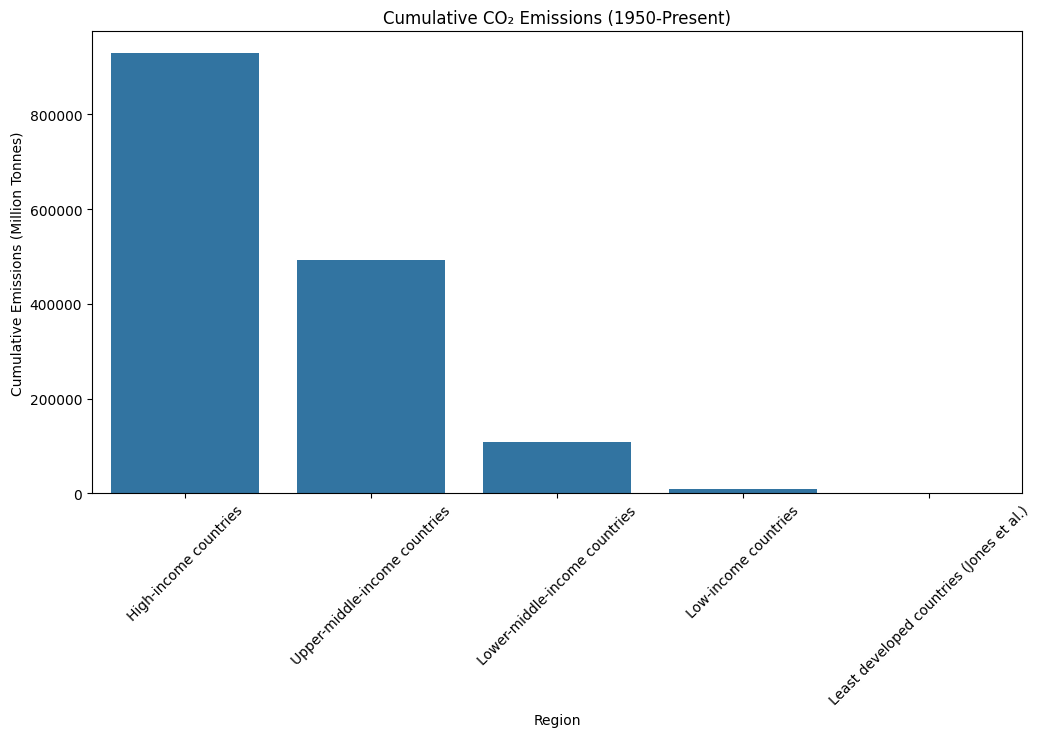

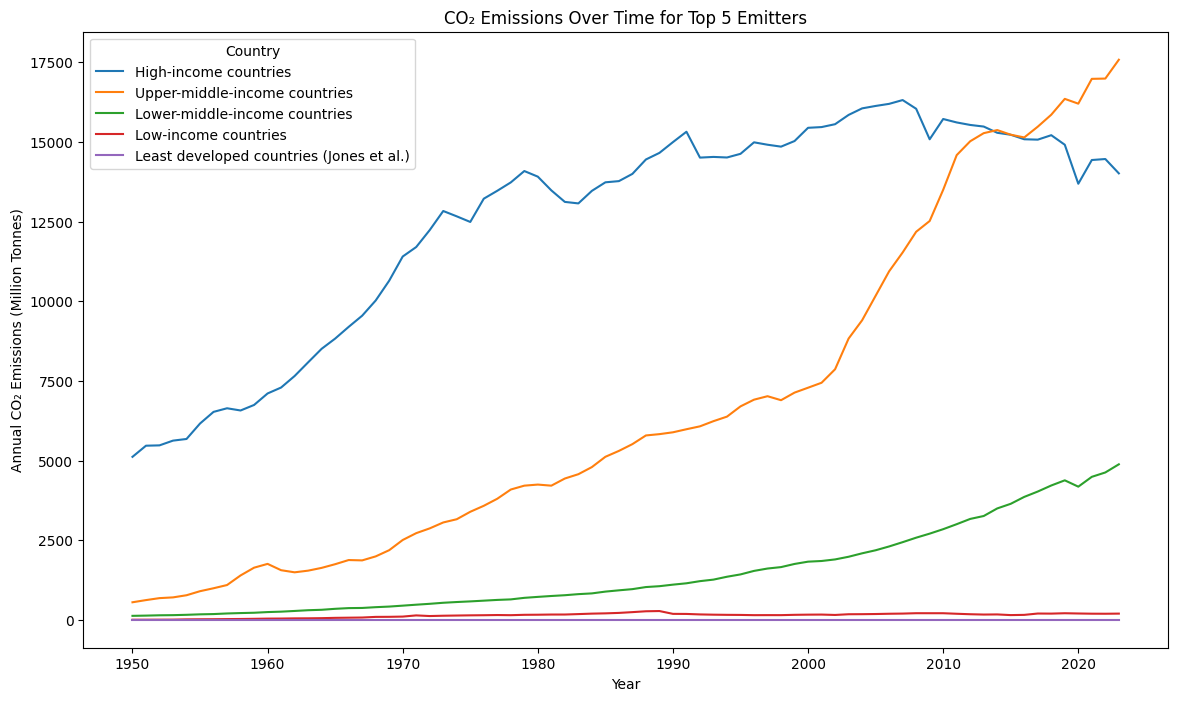

In [11]:
df = get_dataframe_from_cloud(client=client, db_name="data", collection_name="socioeconomic_data")

plot_top_emissions(df)

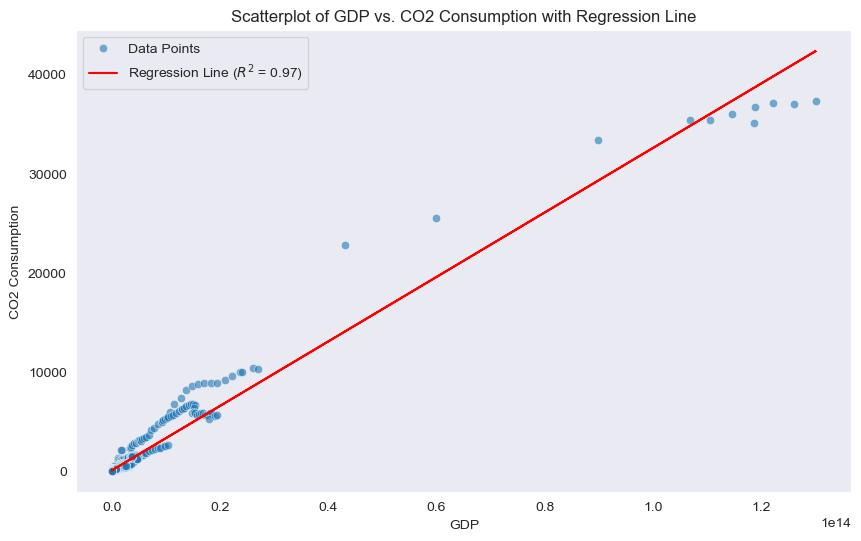

In [26]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

def process_data(df):
    cleaned_data = df.dropna(subset=['gdp', 'consumption_co2'])
    gdp = cleaned_data['gdp']
    consumption_co2 = cleaned_data['consumption_co2']
    return gdp, consumption_co2

gdp, consumption_co2 = process_data(df)

X = gdp.values.reshape(-1, 1)
y = consumption_co2.values

model = LinearRegression()
model.fit(X, y)
y_pred = model.predict(X)

# calculate R^2
r_squared = r2_score(y, y_pred)

# plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x=gdp, y=consumption_co2, alpha=0.6, label='Data Points')
plt.plot(gdp, y_pred, color='red', label=f'Regression Line ($R^2$ = {r_squared:.2f})')
plt.title('Scatterplot of GDP vs. CO2 Consumption with Regression Line')
plt.xlabel('GDP')
plt.ylabel('CO2 Consumption')
plt.legend()
plt.grid()
plt.show()